#### 1. Import required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

#### 2. Read in the data

In [2]:
# folder path containing the csv files
files_path = '../data/'
# list all the files
all_files = os.listdir(files_path)
# filter csv files
csv_files = [file for file in all_files if file.endswith('.csv')]
# read each csv file and store them in a list of dataframes
dfs = [pd.read_csv(os.path.join(files_path, file)) for file in csv_files]
# concate the dataframes
df = pd.concat(dfs, ignore_index=True)
print(f'Number of rows in the data: {df.shape[0]}')
print(f'Number of columns in the data: {df.shape[1]}')

Number of rows in the data: 200
Number of columns in the data: 592


In [3]:
df.head()

,Unnamed: 0,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-6,Sensor-7,Sensor-8,Sensor-9,...,Sensor-582,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
0,Wafer-301,2915.83,2526.29,2197.6778,1056.7817,1.3168,100.0,102.9611,0.1203,1.5091,...,NaN,0.5098,0.0203,0.0051,3.9734,0.0226,0.0106,0.0034,46.9253,-1
1,Wafer-302,2967.04,2273.46,2208.4444,1089.1175,0.7665,100.0,103.7100,0.1201,1.5400,...,NaN,0.5017,0.0134,0.0037,2.6738,0.0226,0.0106,0.0034,46.9253,-1
2,Wafer-303,3057.33,2496.08,2196.6889,1593.1220,1.5925,100.0,99.1133,0.1226,1.4535,...,NaN,0.4983,0.0093,0.0027,1.8608,0.0226,0.0106,0.0034,46.9253,-1
3,Wafer-304,2904.17,2405.53,2204.2667,1475.7797,1.4053,100.0,101.2411,0.1221,1.4941,...,60.6831,0.5031,0.0144,0.0036,2.8608,0.0140,0.0085,0.0036,60.6831,-1
4,Wafer-305,3038.41,2475.67,2224.0000,1510.0797,1.5611,100.0,99.8300,0.1199,1.4783,...,NaN,0.4988,0.0196,0.0052,3.9218,0.0140,0.0085,0.0036,60.6831,-1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Columns: 592 entries, Unnamed: 0 to Good/Bad
dtypes: float64(499), int64(92), object(1)
memory usage: 925.1+ KB


In [5]:
# Rename the column Unnamed: 0
df.rename(columns={'Unnamed: 0': 'Wafer'}, inplace=True)

#### 3. Missing data

Lets us look at missing values in the target feature as well as in other features. 

In [6]:
df['Good/Bad'].isna().sum()

0

In [7]:
df.isna().sum().sum()

5286

In [8]:
# percentage of missing values
percent_missing_values = df.isna().sum().sum() / (df.shape[0] * (df.shape[1]-1))
print(f'Percentage of missing values: {percent_missing_values*100:.2f}%')

Percentage of missing values: 4.47%


There are no missing values in the target feature. However, there are missing values in other features. Around 4.5% out of the total cells have missing values. Later we will impute these missing values.

#### 4. Visualization of Sensor's data

Let's have a look at the data distribution of 50 randomly selected sensors.

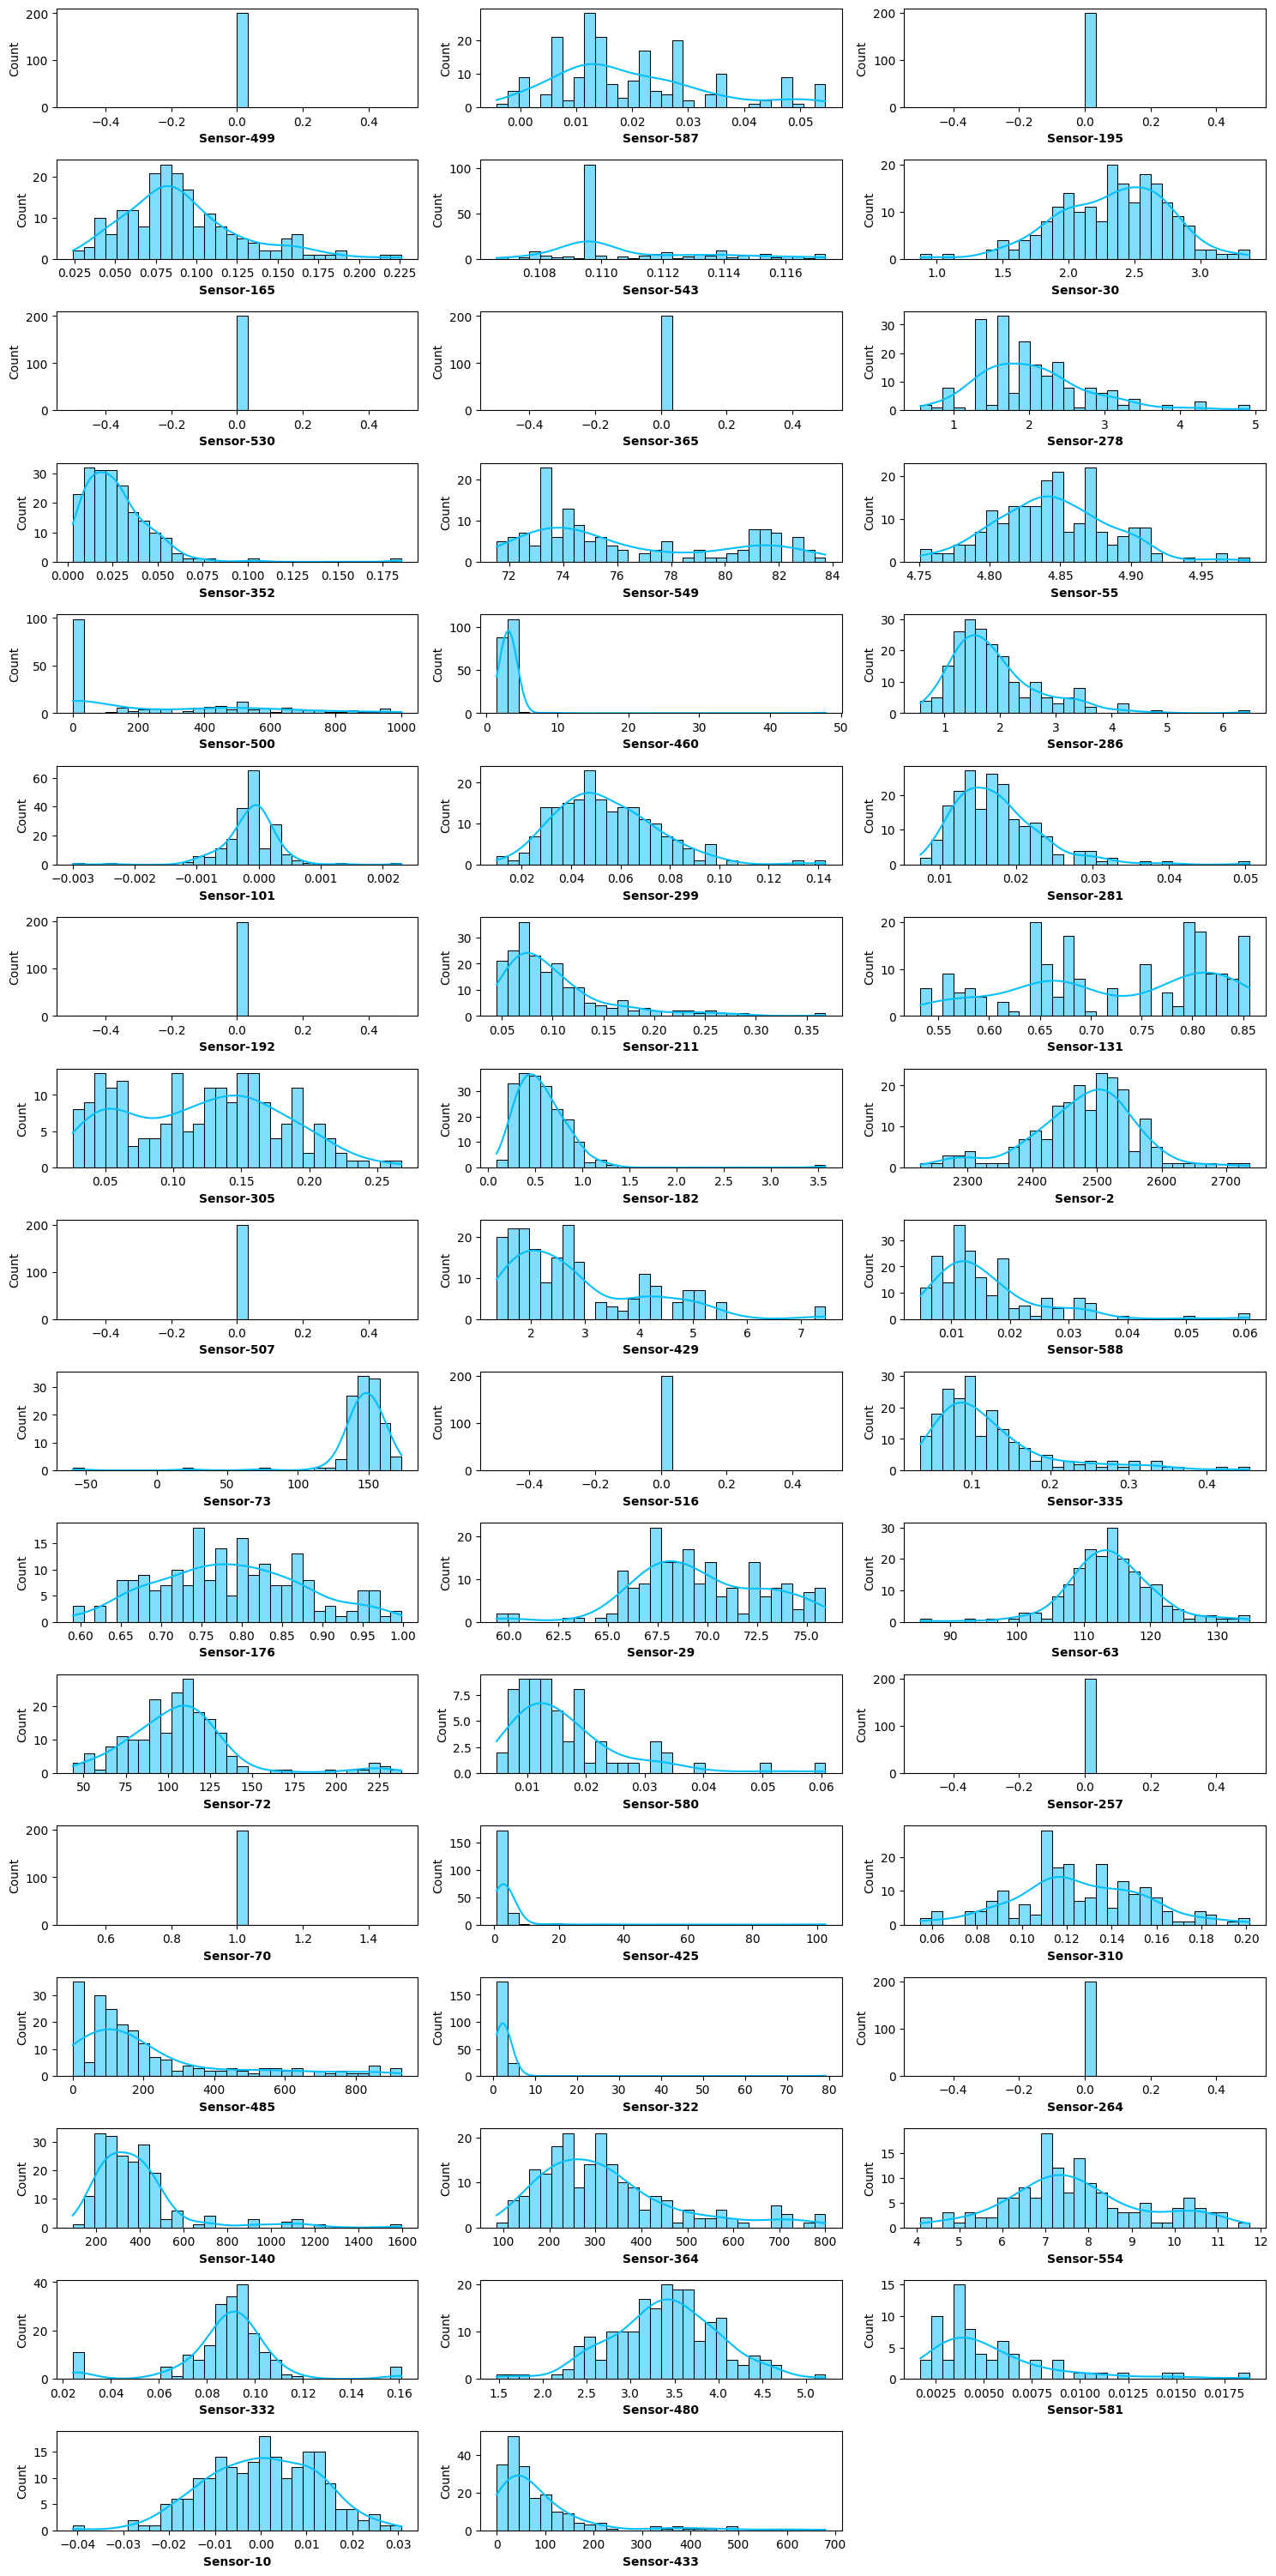

In [9]:
# lets have a look at the data distribution of 50 randomly selected sensors.
col_selected = df.sample(n=50, axis=1, random_state=42).columns

plt.figure(figsize=(15, 35))

for i, col in enumerate(col_selected, start=1):
    plt.subplot(20,3,i)
    sns.histplot(x=df[col], color='deepskyblue', kde=True, bins=30)
    plt.xlabel(col, weight='bold')

plt.tight_layout()
plt.show()

When we look at the distribution plots from random 50 sensors, good amount of them have wither zero standard deviation or skewness (right or left). It is not possible to look at each feature individually and deal with its outliers. Let's come up with some strategies:
- for features with zero standard deviation, we can simply remove them as they dont influence the target variable and thus does not add any value to the further analysis.
- also remove the features/columns that contain more 70% missing values.
- will use robust scaling to deal with the outliers in the other features.

#### 5. Data cleaning

In [10]:
# get a list of the columns with zero standard deviation

def get_cols_with_zero_std(df):

    """
    Takes a dataframe and returns a list of column names that has zero standard deviation.

    Args:
    df: pandas.DataFrame
        The input dataframe for which the columns names have to be returned.

    Returns:
    list
        A list of column names that have zero standard deviation.
    """
    try: 
        cols_with_zero_std = []
        # list all the numerical column names
        num_col_names = [col for col in df.columns if df[col].dtype != 'O']

        for col in num_col_names:
            if df[col].std() == 0:
                cols_with_zero_std.append(col)
        return cols_with_zero_std     
    except Exception as e:
        print(e)
        raise e


In [11]:
# get a list of the columns with missing values more than a given threshold

def get_cols_with_missing_values(df, missing_threshold=0.7):
    """
    Takes a dataframe and returns a list of columns with missing values exceeding a given threshold.

    Args:
    df: pandas.DataFrame
        The input dataframe for which the column names have to be returned.

    missing_threshold: float, optional (default=0.7)
        The threshold value (between 0 and 1) above which columns are considered to have too many missing values.

    Returns:
    list
        A list of column names that have missing values exceeding a specified threshold

    """
    try:
        missing_ratio = df.isna().sum()/df.shape[0]
        cols_with_missing_values = list(missing_ratio[missing_ratio>missing_threshold].index)
        return cols_with_missing_values
    except Exception as e:
        print(e)
        raise e
    

In [12]:
# columns to be dropped
cols_with_zero_std = get_cols_with_zero_std(df)
cols_with_missing_values = get_cols_with_missing_values(df, 0.7)
cols_to_drop = cols_with_zero_std + cols_with_missing_values
# lets add the first column name 'Wafers' to cols_to_drop, as it will not be used for the analysis
cols_to_drop.append('Wafer')

In [13]:
df.drop(cols_to_drop, axis=1, inplace=True)

In [14]:
df.head()

,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-7,Sensor-8,Sensor-9,Sensor-10,Sensor-11,...,Sensor-582,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
0,2915.83,2526.29,2197.6778,1056.7817,1.3168,102.9611,0.1203,1.5091,-0.0064,0.0044,...,NaN,0.5098,0.0203,0.0051,3.9734,0.0226,0.0106,0.0034,46.9253,-1
1,2967.04,2273.46,2208.4444,1089.1175,0.7665,103.7100,0.1201,1.5400,-0.0167,-0.0036,...,NaN,0.5017,0.0134,0.0037,2.6738,0.0226,0.0106,0.0034,46.9253,-1
2,3057.33,2496.08,2196.6889,1593.1220,1.5925,99.1133,0.1226,1.4535,0.0141,0.0026,...,NaN,0.4983,0.0093,0.0027,1.8608,0.0226,0.0106,0.0034,46.9253,-1
3,2904.17,2405.53,2204.2667,1475.7797,1.4053,101.2411,0.1221,1.4941,0.0037,0.0086,...,60.6831,0.5031,0.0144,0.0036,2.8608,0.0140,0.0085,0.0036,60.6831,-1
4,3038.41,2475.67,2224.0000,1510.0797,1.5611,99.8300,0.1199,1.4783,-0.0129,-0.0051,...,NaN,0.4988,0.0196,0.0052,3.9218,0.0140,0.0085,0.0036,60.6831,-1


Before going further, split the data into test and train set.

In [15]:
# Split the data into train and test set

df, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Good/Bad'])
print(f'shape of df: {df.shape}')
print(f'shape of df_test: {df_test.shape}')

shape of df: (160, 449)
shape of df_test: (40, 449)


In [16]:
df['Good/Bad'].value_counts()

Good/Bad
-1    149
 1     11
Name: count, dtype: int64

In [17]:
df_test['Good/Bad'].value_counts()

Good/Bad
-1    37
 1     3
Name: count, dtype: int64

In [18]:
X, Y = df.iloc[:, :-1], df[['Good/Bad']]

#### 6. Data transformation

We have already dealt with the columns with zero standard deviation and columns containing more than 70% of missing values. Let's now imput the missing values in the remaining features by using KNN imputer and transform the data using RobustScaler as it is robust to outliers.

In [19]:
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

imputer = KNNImputer(n_neighbors=3)

preprocessing_pipeline = Pipeline(
    steps=[
        ('Imputer', imputer),
        ('Scaler', RobustScaler())
    ]
)

In [20]:
# Transform the training data
X_trans = preprocessing_pipeline.fit_transform(X)

#### 7. Data exploration and pattern detection

Let's check if we can detect any clustering patterns in the data. Here I will try PCA to explore and potentially identify clusters visually.


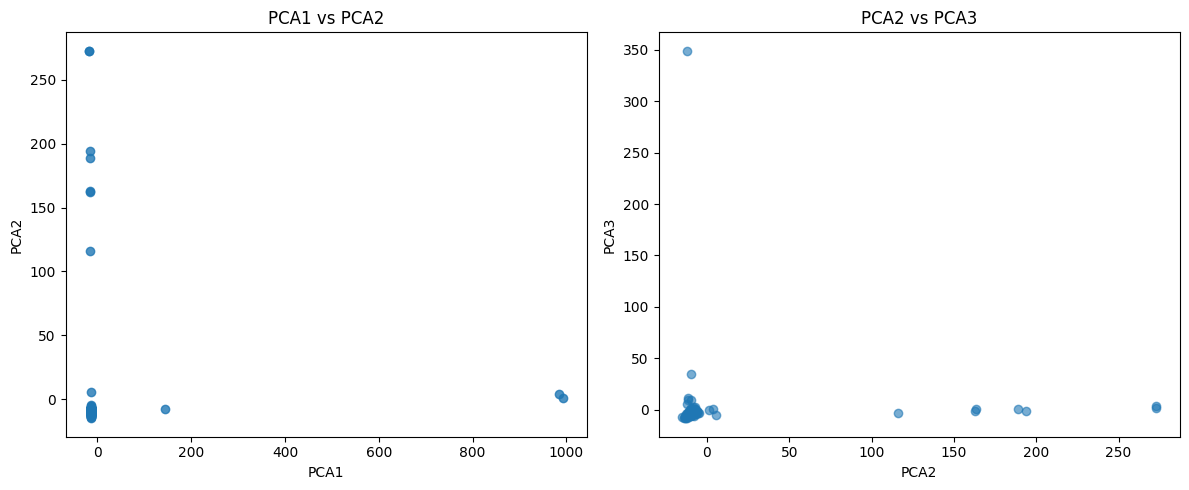

In [21]:
from sklearn.decomposition import PCA

# PCA to explore potential clusters
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_trans)

## plot the components
fig, (ax1, ax2) = plt.subplots(1,2 , figsize=(12,5))
ax1.scatter(x=X_pca[:,0], y=X_pca[:,1], alpha=0.8)
ax1.set_xlabel('PCA1')
ax1.set_ylabel('PCA2')
ax1.set_title('PCA1 vs PCA2')

ax2.scatter(x=X_pca[:,1], y=X_pca[:,2], alpha=0.6)
ax2.set_xlabel('PCA2')
ax2.set_ylabel('PCA3')
ax2.set_title('PCA2 vs PCA3')

plt.tight_layout()
plt.show()

From the above visualization, it appears that there is no striking clustering pattern in the data. As a second approch, lets use k-means clustering as well to detect clusters.

In [22]:
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

## Get within cluster sum of squares
def calculate_wcss(X, max_clusters=10, random_state=42):
    """
    Takes transformed features data and returns the within cluster sum of squares for a given number of clusters.

    Args:
    X: np.array
        Transformed features data.
    max_clusters: int, optional (default=10)
        Maximum number of clusters to consider. 
    random_state: int, optional (default=42)
        The random seed used for kmeans clustering.      

    Returns:
    int
        Ideal number of clusters the given data should be divided into.

    """
    try:
        # within clusster sum of squares
        wcss = []
        for i in range(1,max_clusters+1):
            kmeans = KMeans(n_clusters=i, init='k-means++', random_state=random_state)
            kmeans.fit(X)
            wcss.append(kmeans.inertia_)
        return wcss    

    except Exception as e:
        print(e)
        raise e    

## Plot elbow curve
def plot_elbow_curve(wcss, max_clusters=10):
    """
    Given a list of wcss i.e., within cluster sum of squares, the function will plot a elbow curve.

    Args:
    wcss: list
        List of wcss values.
    max_clusters: int, optional (default=10)
        Maximum number of clusters to consider.     

    Returns:
    None

    """

    try:
        k_range = range(1, max_clusters+1)
        plt.figure(figsize=(6,4))
        plt.plot(k_range, wcss, marker='o')
        plt.title('Elbow curve for optimal K')
        plt.xticks(k_range)
        plt.xlabel('Numer of clusters')
        plt.ylabel('WCSS')
        plt.show()

    except Exception as e:
        print(e)
        raise e    

# Get silhoutette scores
def calculate_silhouette_score(X, max_clusters=10, random_state=42): 
    """
    Takes transformed features data and returns the silhoutte scores for the clusters.

    Args:
    X: np.array
        Transformed features data.
    max_clusters: int, optional (default=10)
        Maximum number of clusters to consider. 
    random_state: int, optional (default=42)
        The random seed used for kmeans clustering.      

    Returns:
    int
        Ideal number of clusters the given data should be divided into.

    """ 
    try: 
        s_scores = []
        for i in range(2, max_clusters+1):
            kmeans = KMeans(n_clusters=i, init='k-means++', random_state=random_state)
            kmeans.fit(X)
            score = silhouette_score(X, kmeans.labels_)
            s_scores.append(score)
        return s_scores

    except Exception as e:
        print(e)
        raise e    
# Plot silhouette scores
def plot_silhouette_scores(s_scores, max_clusters=10):
    """
    Given a list of silhoutte scores, the function will generate a plot

    Args:
    s_scores: list
        List of silhouette scores.
    max_clusters: int, optional (default=10)
        Maximum number of clusters to consider.     

    Returns:
    None

    """

    try:
        k_range = range(2, max_clusters+1)
        plt.figure(figsize=(6,4))
        plt.plot(k_range, s_scores, marker='o')
        plt.title('Silhouette scores for various clusters')
        plt.xticks(k_range)
        plt.xlabel('Numer of clusters')
        plt.ylabel('Silhouette scores')
        plt.show()

    except Exception as e:
        print(e)
        raise e    
   

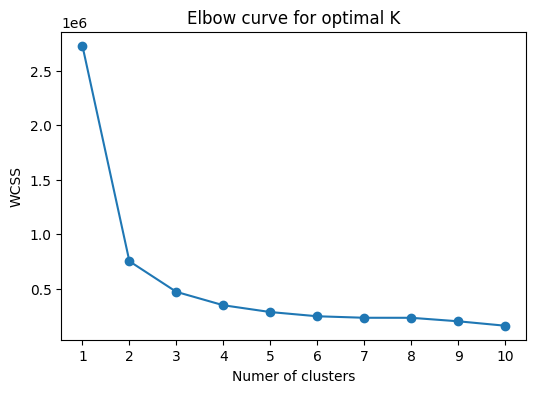

In [23]:
# Elbow method
wcss = calculate_wcss(X_trans, 10, 42)
plot_elbow_curve(wcss, 10)

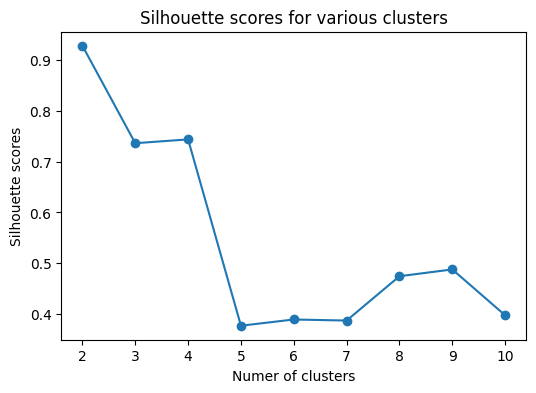

In [24]:
#silhoutte score
s_scores = calculate_silhouette_score(X_trans, 10, 42)
plot_silhouette_scores(s_scores, 10)

In [25]:
# Find optimal number of clusters using wcss
 
def find_optimal_clusters(wcss):
    """
    Finds the optimal number of cluster using Knee locator method.

    Args:
    wcss: list
        List of wcss values.  

    Returns:
    int
        The optimal number of clusters
    
    """

    try:
        knee_locator = KneeLocator(range(1, len(wcss)+1), wcss, curve='convex', direction='decreasing')
        optimal_clusters = knee_locator.knee
        return optimal_clusters
    except Exception as e:
        print(e)
        raise e
    

In [26]:
# optimal  number of clusters with elbow method
optimal_cluster = find_optimal_clusters(wcss)
print(f'Optimal number of clusters with elbow method: {optimal_cluster}')

Optimal number of clusters with elbow method: 2


In [27]:
# Find optimal number of clusters using silhouette scores
optimal_clusters_s_scores = s_scores.index(max(s_scores)) + 2 # +2 to account for range starting at 2
print(f'Optimal number of clusters using silhoutte method: {optimal_clusters_s_scores}')

Optimal number of clusters using silhoutte method: 2


From both Elbow method and Silhouette method, the optimal number of clusters is 2. So let us divide the data into 2 clusters and explore how many records are there for each cluster.

In [28]:
# create clusters
def divide_data_into_clusters(X, optimal_clusters, random_state=42):
    """
    Divides the data into clusters using the optimal number of clusters.
    
    Args:
    X: np.array
        Transformed data.
    optimal_clusters: int
        Optimal number of clusters
    random_state: int, optional (default=42)
        The random seed used for kmeans clustering.

    Returns:
    np.array
        Cluster labels for each data point        
    """
    try:
        kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=random_state)
        cluster_labels = kmeans.fit_predict(X)
        return cluster_labels
    except Exception as e:
        print(e)
        raise e

In [29]:
cluster_labels = divide_data_into_clusters(X_trans, 2, 42)
np.unique(cluster_labels)

array([0, 1], dtype=int32)

Dataset was divided into 2 clusters. Let's look how many records or data points are there for each cluster.

In [30]:
pd.Series(cluster_labels).value_counts().sort_index()

0    158
1      2
Name: count, dtype: int64

We can see that, although the optimal number of clusters were detected as 2,most of the data points are in cluster 0 and cluster 1 has only 2 data point. So, it does not make sense to cluster the data for further analysis.

When we look the target variable, it is apparent that the data is highly imbalanced. Therefore, it is imperative to resample the data in order to deal with imbalanced data.

In [31]:
Y.value_counts()

Good/Bad
-1          149
 1           11
Name: count, dtype: int64

#### 8. Data resampling to deal with the imbalanced data

In [32]:
from imblearn.combine import SMOTETomek

resampler = SMOTETomek(sampling_strategy='auto')
X_resampled, Y_resampled = resampler.fit_resample(X_trans, Y)

In [33]:
print(f'Shape of training data before resampling: {np.c_[X_trans, Y].shape}')
print(f'Shape of training data after resampling: {np.c_[X_resampled, Y_resampled].shape}')


Shape of training data before resampling: (160, 449)
Shape of training data after resampling: (298, 449)


In [34]:
# check the target variable counts

Y_resampled.value_counts()

Good/Bad
-1          149
 1          149
Name: count, dtype: int64

We can see that now we have same number of data points for Good and Bad. That's what we wanted.

#### 9. Model training

We will train different models and evaluate them. Based on their performance we can choose the final model.

In [35]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict

# Base models
svc_clf = SVC(kernel='linear', probability=True)
svc_rbf_clf = SVC(kernel='rbf', probability=True)
rf_clf = RandomForestClassifier(random_state=42)
xgb_clf = XGBClassifier(objective='binary:logistic', random_state=42)

In [36]:
# Function to disply scores

def display_scores(scores):
    """
    Given scores from the machine learning model as input, displays the scores, mean and standard deviation.

    Args: array-like
        Scores to be displayed typically from cross-validation

    Returns:
    None
    """

    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

**SVC (kernel='linear') model:**

In [37]:
svc_clf_scores = cross_val_score(svc_clf, X_resampled, Y_resampled, scoring='roc_auc', cv=10, verbose=2)
# display scores
display_scores(svc_clf_scores)

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
Scores: [0.93333333 1.         1.         0.86666667 1.         1.
 1.         1.         1.         1.        ]
Mean: 0.9800000000000001
Standard deviation: 0.04268749491621898


**SVC (kernel='rbf') model**

In [38]:
svc_rbf_scores = cross_val_score(svc_rbf_clf, X_resampled, Y_resampled, scoring='roc_auc', cv=10, verbose=2)

#display scores
display_scores(svc_rbf_scores)

[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
Scores: [0.92888889 1.         1.         0.88444444 0.99555556 0.88444444
 0.98666667 1.         1.         1.        ]
Mean: 0.968
Standard deviation: 0.04660525059170962


**RandomForestClassifier model**

In [39]:
rf_clf_scores = cross_val_score(rf_clf, X_resampled, Y_resampled, scoring='roc_auc', cv=10, verbose=2)

#display scores
display_scores(rf_clf_scores)

[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
Scores: [1.         1.         1.         0.99777778 1.         1.
 1.         1.         1.         1.        ]
Mean: 0.9997777777777778
Standard deviation: 0.0006666666666666636


**XGBoost model**

In [40]:
# adjust target labels i.e., instead of [-1, 1], make it as [0,1]

Y_resampled_adjusted = np.where(Y_resampled == -1, 0, Y_resampled)
xgb_clf_scores = cross_val_score(xgb_clf, X_resampled, Y_resampled_adjusted, scoring='roc_auc', cv=10, verbose=2)

# display scores
display_scores(xgb_clf_scores)

[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
Scores: [0.99555556 1.         1.         0.98666667 1.         0.99111111
 1.         1.         0.99047619 1.        ]
Mean: 0.9963809523809524
Standard deviation: 0.004860772582964609


#### 10. Model evaluation

Firstly, prepare the test data. We had split the data in the beginning into to test and train data. Now process and transform the test data similar to training data.

In [41]:
df_test.head()

,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-7,Sensor-8,Sensor-9,Sensor-10,Sensor-11,...,Sensor-582,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
53,3037.81,2305.52,2186.9889,949.2201,1.2981,103.3322,0.1219,1.5169,0.0136,0.0019,...,113.2841,0.4996,0.0137,0.0034,2.7410,0.0536,0.0607,0.0188,113.2841,-1
139,3019.38,2499.75,2200.9556,1126.8678,0.7860,100.3700,0.1215,1.4445,-0.0154,0.0125,...,223.1018,0.4954,0.0139,0.0036,2.8009,0.0117,0.0262,0.0089,223.1018,-1
69,2996.53,2533.52,2202.1222,1034.5674,0.7760,104.6156,0.1219,1.5320,0.0068,-0.0173,...,NaN,0.5022,0.0156,0.0037,3.1083,0.0120,0.0104,0.0036,86.7035,-1
186,2998.01,2479.77,2189.9667,1046.6212,0.8662,102.3622,0.1208,1.3952,-0.0198,0.0026,...,NaN,0.4958,0.0115,0.0031,2.3185,0.0280,0.0078,0.0022,27.7601,-1
111,3008.28,2504.21,2202.2556,1914.0689,1.6013,94.6922,0.1242,1.4055,-0.0134,-0.0135,...,NaN,0.4989,0.0125,0.0032,2.5022,0.0128,0.0193,0.0060,151.1930,-1


In [42]:
print(f'shape of test data: {df_test.shape}')

shape of test data: (40, 449)


In [43]:
X_test, Y_test = df_test.iloc[:, :-1], df_test[['Good/Bad']]

In [44]:
Y_test.value_counts()

Good/Bad
-1          37
 1           3
Name: count, dtype: int64

In [45]:
# Transform the test data

X_test_trans = preprocessing_pipeline.transform(X_test)

**SVC (kernel='linear')**

In [46]:
from sklearn.metrics import accuracy_score
svc_clf.fit(X_resampled, Y_resampled)

# performance on test data

svc_clf_predictions = svc_clf.predict(X_test_trans)
svc_clf_proba = svc_clf.predict_proba(X_test_trans)[:, 1]

# print model name
print('Model: SVC, kernel=linear')

# Calculate accuracy
accuracy = accuracy_score(Y_test, svc_clf_predictions)
print(f'Accuracy: {accuracy}')

# Calculate AUC-ROC
auc_roc = roc_auc_score(Y_test, svc_clf_proba)
print(f'AUC-ROC: {auc_roc}')

Model: SVC, kernel=linear
Accuracy: 0.875
AUC-ROC: 0.8108108108108109


**Evaluating SVC (kernel='rbf')**

In [47]:
svc_rbf_clf.fit(X_resampled, Y_resampled)

# performance on test data

svc_rbf_clf_predictions = svc_rbf_clf.predict(X_test_trans)
svc_rbf_clf_proba = svc_rbf_clf.predict_proba(X_test_trans)[:, 1]

# print model name
print('Model: SVC, kernel=rbf')

# Calculate accuracy
accuracy = accuracy_score(Y_test, svc_rbf_clf_predictions)
print(f'Accuracy: {accuracy}')

# Calculate AUC-ROC
auc_roc = roc_auc_score(Y_test, svc_rbf_clf_proba)
print(f'AUC-ROC: {auc_roc}')

Model: SVC, kernel=rbf
Accuracy: 0.825
AUC-ROC: 0.6846846846846847


**Evaluating RandomForestClassifier**

In [51]:
rf_clf.fit(X_resampled, Y_resampled)

# performance on test data

rf_clf_predictions = rf_clf.predict(X_test_trans)
rf_clf_proba = rf_clf.predict_proba(X_test_trans)[:, 1]

# print model name
print('Model: RandomForestClassifier')

# Calculate accuracy
accuracy = accuracy_score(Y_test, rf_clf_predictions)
print(f'Accuracy: {accuracy}')

# Calculate AUC-ROC
auc_roc = roc_auc_score(Y_test, rf_clf_proba)
print(f'AUC-ROC: {auc_roc}')

Model: RandomForestClassifier
Accuracy: 0.925
AUC-ROC: 0.7657657657657657


**Evaluating XGBoost**

In [52]:
xgb_clf.fit(X_resampled, Y_resampled_adjusted)

Y_test_adjusted = np.where(Y_test == -1, 0, Y_test) # adjust target labels i.e., instead of [-1, 1], make it as [0,1]

# performance on test data

xgb_clf_predictions = xgb_clf.predict(X_test_trans)
xgb_clf_proba = xgb_clf.predict_proba(X_test_trans)[:, 1]

# print model name
print('Model: XGBoost')

# Calculate accuracy
accuracy = accuracy_score(Y_test_adjusted, xgb_clf_predictions)
print(f'Accuracy: {accuracy}')

# Calculate AUC-ROC
auc_roc = roc_auc_score(Y_test_adjusted, xgb_clf_proba)
print(f'AUC-ROC: {auc_roc}')

Model: XGBoost
Accuracy: 0.9
AUC-ROC: 0.8468468468468469


From the comaparisons between different machine learning models, although RandomForestClassifier has accuracy of 0.92, XGboost has higher AUC ROC score. 